This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os
import importlib


# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs; importlib.reload(fbs)
import f90nml
#import gradstuff as gds

CUDA not available.


In [2]:
%matplotlib notebook

In [3]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments1'
imageroot = '2016-06-30_ice1_rough1'
Calibrationfile = '../case1 (calibration)/Calibration.nml'

/Users/katiegray/ice4
atiegray/ice4


In [4]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments1_retrieved.npz
Segments1_roughness.jpg
Segments1_roughness.txt


In [5]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'retrieved'

In [6]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

FileNotFoundError: [Errno 2] No such file or directory: 'SEMimages/2016-06-30_ice1_rough1-A.bmp'

In [77]:
# This cell loads the image and superimposes the segment boxes

# Load the image
im = PIL.Image.open(Filename)

# Extract
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)

# Show it
plt.figure()
# plt.show(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255) # This shouldn't be necessary but there seems to be a bug with plt.show

# Save a copy
im.save(SEMSegmentjpgfile)

# Parameters for selecting out the actual solution
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

# Graphics parameters
surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)

350
250


In [78]:
# Just echo calibration file name
print(Calibrationfile)

# Extract calibration data
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path

../case1 (calibration)/Calibration.nml


In [79]:
# These are parameters important for the retrieval

# Generic retrieval parameters
maxiter = 5
tolerance = 10
rootnoiseamp = 2.5 # This is in SEM image amplitide
rootapriorivar0 = 15 # This is in micrometers

# Size of the kernel (probably don't have to change these)
nptsx = 103
nptsy = 101
nmax = 5

In [80]:
# Retrieve
solution = fbs.retrieveall(\
        nmax,maxiter,tolerance,rootnoiseamp,rootapriorivar0,\
        nsegments,nptsx,nptsy,nx1list,ny1list,nx2list,ny2list,nyxgrid,dx,dy,\
        Calibration,cA,cB,cC,cD)

nxigrid.shape= (101, 103)

for 250 120
Segment: 1 of 35
Observed intensities (detector B):
mean, max, min = 79.3896 105.0 42.0
<diff>, std(diff), di2 = 2.5456915038448544 11.640665600350665 109301.67042140028
<diff>, std(diff), di2 = 0.889731831871571 8.509187956151612 1330.2760215362982
<diff>, std(diff), di2 = 0.712940515061736 8.474952474856698 22.76660599449007
<diff>, std(diff), di2 = 0.6970626826306084 8.475305330575951 0.5345681468803588

for 250 170
Segment: 2 of 35
Observed intensities (detector B):
mean, max, min = 80.2616 99.0 59.0
<diff>, std(diff), di2 = 3.846791503844854 9.213836304051549 93070.65486397299
<diff>, std(diff), di2 = 2.1968161704541753 5.978012348539496 591.7317866811227
<diff>, std(diff), di2 = 2.0761012802382486 5.988865751479503 2.9494194545243015
Noverlap = 51

for 250 220
Segment: 3 of 35
Observed intensities (detector B):
mean, max, min = 82.3144 100.0 60.0
<diff>, std(diff), di2 = 2.9897915038448546 9.559261286032973 126024.3096704002
<diff>, std(diff


for 450 220
Segment: 23 of 35
Observed intensities (detector B):
mean, max, min = 82.8048 98.0 67.0
<diff>, std(diff), di2 = 3.283691503844854 9.211390875497202 131171.4489806652
<diff>, std(diff), di2 = 1.1278450790905095 3.4780414106400097 782.3564143301741
<diff>, std(diff), di2 = 0.9604017619561568 3.4555571286870244 3.1525488602924847
Noverlap = 104

for 450 270
Segment: 24 of 35
Observed intensities (detector B):
mean, max, min = 83.914 100.0 68.0
<diff>, std(diff), di2 = 3.1470915038448544 9.901530009027839 151425.28470500105
<diff>, std(diff), di2 = 0.7802656899513372 3.56462303056735 1068.2441029641893
<diff>, std(diff), di2 = 0.5750890384873456 3.506928025462105 5.037723592936836
Noverlap = 104

for 450 320
Segment: 25 of 35
Observed intensities (detector B):
mean, max, min = 83.2868 100.0 70.0
<diff>, std(diff), di2 = 3.357091503844854 9.469906862154902 141227.3406275481
<diff>, std(diff), di2 = 1.1331827815572495 3.341694393793658 930.3682749025899
<diff>, std(diff), di2 =

<IPython.core.display.Javascript object>


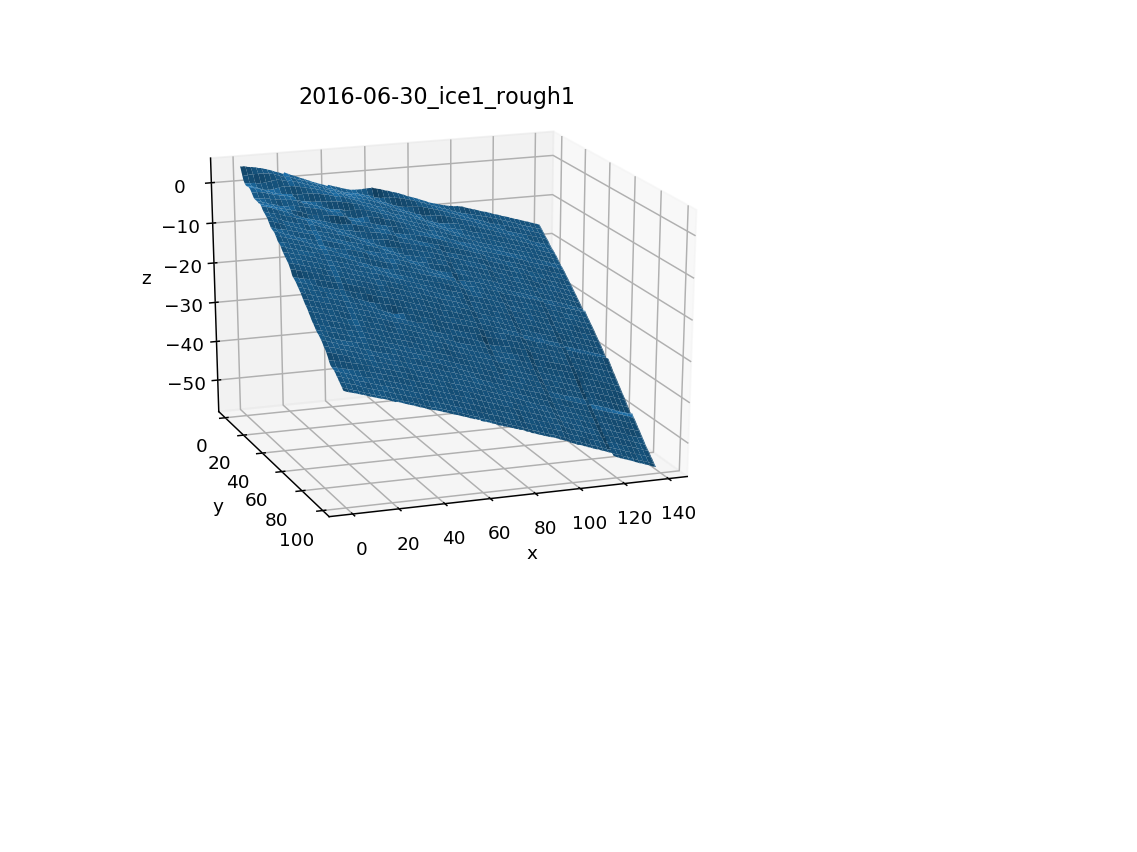

In [86]:
# Show the reconstructed surface
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=6,cstride=6)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [85]:
# Save the image with the retrieved segments
print("saving", Retrievedjpgfile)
fig.savefig(Retrievedjpgfile)

saving Segments1retrieved.jpg


In [89]:
print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    solution=solution)

saving Segments1retrieved
